# <center>Logistic Regression</center>

In [27]:
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import torch
import torchmetrics
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
import seaborn as sns
import tenseal as ts

In [28]:
# Importing the dataset and undersampling it to avoid biases
df = pd.read_csv(r"C:\Users\manig\Downloads\Mitacs\top_features.csv")
grouped = df.groupby('Label')
df = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
x = df.drop(["Label"], axis = 1)
y = df["Label"]

# Scaling
scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

#Splitting the dataset into training, testing and validation set
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.20, random_state=42)
x_val, x_test_20, y_val, y_test_20 = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
x_train=torch.from_numpy(x_train).float()
x_val=torch.from_numpy(x_val).float()
x_test_20=torch.from_numpy(x_test_20).float()
y_train=torch.from_numpy(np.array(y_train)).float().unsqueeze(1)
y_val=torch.from_numpy(np.array(y_val)).float().unsqueeze(1)
y_test_20=torch.from_numpy(np.array(y_test_20)).float().unsqueeze(1)
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test_20.shape}")
print(f"y_test shape: {y_test_20.shape}")

x_train shape: torch.Size([681185, 30])
y_train shape: torch.Size([681185, 1])
x_val shape: torch.Size([85148, 30])
y_val shape: torch.Size([85148, 1])
x_test shape: torch.Size([85149, 30])
y_test shape: torch.Size([85149, 1])


In [29]:
del grouped, df, x, y

In [30]:
# Logistic Regression Model
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

In [6]:
# Validation function
def validate(model, criterion, x_val, y_val):
    model.eval()  
    with torch.no_grad():  
        outputs = model(x_val)
        loss = criterion(outputs, y_val)
        acc, _ = accuracy(model, x_val, y_val)
    model.train()  
    return loss.item(), acc

In [7]:
# Training function
def train(model, optimizer, criterion, x, y, x_val, y_val, epochs):
    train_loss_dict = {}
    train_acc_dict = {}
    val_loss_dict = {}
    val_acc_dict = {}
    for e in range(1, epochs + 1):
        def closure():
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss
        optimizer.step(closure)
#         scheduler.step(closure().item())
        train_loss = closure().item()
        train_loss_dict[e] = train_loss
        train_acc, _ = accuracy(model, x, y)
        train_acc_dict[e] = train_acc
        val_loss, val_acc = validate(model, criterion, x_val, y_val)
        val_loss_dict[e] = val_loss
        val_acc_dict[e] = val_acc
        if e%50 == 0:
            print(f"Epoch {e} - Training loss: {train_loss}, Training accuracy: {train_acc}, Validation loss: {val_loss}, Validation accuracy: {val_acc}, Learning Rate: {optimizer.param_groups[0]['lr']}\n")
    return model, train_loss_dict, train_acc_dict, val_loss_dict, val_acc_dict

In [31]:
def accuracy(model, x, y, train=True):
    out_list = []
    t_start = time.time()
    out = model(x)
    t_end = time.time()
    if(train==False):
        print(f"Prediction Time: {(t_end - t_start)} seconds")
    out_list.append(out)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean(), out

Epoch 50 - Training loss: 0.20990997552871704, Training accuracy: 0.9234334230422974, Validation loss: 0.2119133025407791, Validation accuracy: 0.9239559173583984, Learning Rate: 0.001

Epoch 100 - Training loss: 0.20727108418941498, Training accuracy: 0.9258674383163452, Validation loss: 0.21026445925235748, Validation accuracy: 0.9258584976196289, Learning Rate: 0.001

Epoch 150 - Training loss: 0.20681239664554596, Training accuracy: 0.9241263270378113, Validation loss: 0.2090817540884018, Validation accuracy: 0.9239206910133362, Learning Rate: 0.001

Epoch 200 - Training loss: 0.2069191187620163, Training accuracy: 0.9240558743476868, Validation loss: 0.20905396342277527, Validation accuracy: 0.9239324331283569, Learning Rate: 0.001

Epoch 250 - Training loss: 0.20678727328777313, Training accuracy: 0.9239927530288696, Validation loss: 0.2090412676334381, Validation accuracy: 0.9238502383232117, Learning Rate: 0.001

Epoch 300 - Training loss: 0.20678101480007172, Training accuracy

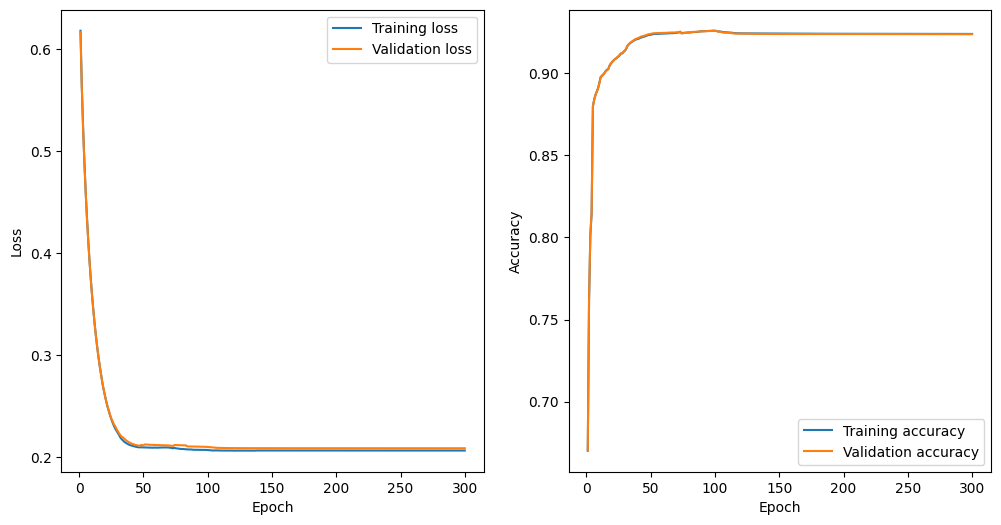

In [24]:
# Training and validating the model on unencrypted data
n_features = x_train.shape[1]
torch.random.manual_seed(42)
random.seed(42)
model = LR(n_features)
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.001, max_iter=100)
criterion = torch.nn.BCELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
EPOCHS = 300

t_start = time.time()
model, train_loss_dict, train_acc_dict, val_loss_dict, val_acc_dict  = train(model, optimizer, criterion, x_train, y_train, x_val, y_val, EPOCHS)
t_end = time.time()
print(f"Training Time: {int(t_end - t_start)} seconds")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(*zip(*train_loss_dict.items()), label='Training loss')
ax1.plot(*zip(*val_loss_dict.items()), label='Validation loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(*zip(*train_acc_dict.items()), label='Training accuracy')
ax2.plot(*zip(*val_acc_dict.items()), label='Validation accuracy')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
plt.show()

From the loss and accuracy curve, we can see that the model neither overfitted nor underfitted

In [32]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "lr.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [39]:
# Saving the model weights and biases
# print(f"Saving model to: {MODEL_SAVE_PATH}")
# torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH) 

Saving model to: models\lr.pth


In [33]:
# Loading the model weights and biases
model = LR(30)
model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [29]:
op_df = pd.DataFrame({
    "Original": op.squeeze().detach().numpy()})
op_df.head()

,Original
0,0.000965
1,0.107859
2,0.999993
3,0.002897
4,0.999975


In [10]:
# Testing - Calculating Accuracy, Recall, Precision and F1- Score on unencrypted data
op = op.squeeze().detach().numpy()
for i in range(len(op)):
    if op[i]<0.5:
        op[i] = 0
    else:
        op[i] = 1
y_test_temp = y_test_20.squeeze().numpy()
plain_accuracy = accuracy_score(y_test_temp, op)
plain_recall = recall_score(y_test_temp, op, average='binary')  
plain_f1 = f1_score(y_test_temp, op, average='binary')  
plain_precision = precision_score(y_test_temp, op, average='binary')  
print(f"Accuracy: {plain_accuracy}")
print(f"Recall: {plain_recall}")
print(f"Precision: {plain_precision}")
print(f"F1 - Score: {plain_f1}")

Accuracy: 0.9221482342716885
Recall: 0.9659731354499342
Precision: 0.8881571844974631
F1 - Score: 0.9254322320836006


In [34]:
# Class to define forward function for encrypted model evaluation using weights and biases
class EncryptedLR:
    
    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        
    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
eelr = EncryptedLR(model)

In [12]:
# Defining TenSEAL Context
poly_mod_degree = 8192
coeff_mod_bit_sizes = [60, 40, 60]
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_eval.global_scale = 2 ** 40
ctx_eval.generate_galois_keys()

In [33]:
# eelr.encrypt(ctx_eval)

In [13]:
# This function evaluates on encrypted data and applies sigmoid operation after decryption
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time.time()
    output_list = []
    correct = 0
    for enc_x, y in zip(enc_x_test, y_test):
        enc_out = model(enc_x)
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        if torch.abs(out - y) < 0.5:
            correct += 1
        output_list.append(out)
    t_end = time.time()
    print(f"Evaluated test set of {len(enc_x_test)} entries in {int(t_end - t_start)} seconds")
    print(f"Score: {correct}/{len(enc_x_test)}")
    return correct / len(enc_x_test), output_list

In [14]:
# Splitting the test set into 20 parts and testing them individually 
# (did this because testing 1/20th of testing set id faster than testing the whole set at one so it helps to check accuracy and tell whether the parameters selected are good or bad upto some extent)
y_pred_final = []
one_part = y_test_20.shape[0] // 20
for i in range(1, 21):
    if i==1:
        j = one_part
        temp_x_test = x_test_20[:j,]
        temp_y_test = y_test_20[:j,]
    elif i==20:
        j = one_part * (i-1)
        temp_x_test = x_test_20[j:,]
        temp_y_test = y_test_20[j:,]
    else:
        j = one_part * i
        if i == 1:
            k = one_part
        else:
            k = one_part * (i-1)
        temp_x_test = x_test_20[k:j,]
        temp_y_test = y_test_20[k:j,]
    
    t_start = time.time()
    enc_x_test = []
    print(f"Starting Batch {i} Encryption")
    for x in tqdm(range(len(temp_x_test))):
        enc_x_test.append(ts.ckks_vector(ctx_eval, temp_x_test[x].tolist()))
    t_end = time.time()
    print(f"Encryption of the test set took {int(t_end - t_start)} seconds")
    encrypted_accuracy, output_list = encrypted_evaluation(eelr, enc_x_test, temp_y_test)
    print(f"Batch {i} Encrypted Accuracy: {encrypted_accuracy}")
    y_pred = torch.cat(output_list)
    y_pred = y_pred.numpy()
    y_pred_final.extend(y_pred)

Starting Batch 1 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:19<00:00, 222.06it/s]


Encryption of the test set took 19 seconds
Evaluated test set of 4257 entries in 56 seconds
Score: 3917/4257
Batch 1 Encrypted Accuracy: 0.9201315480385248
Starting Batch 2 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 239.17it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 54 seconds
Score: 3908/4257
Batch 2 Encrypted Accuracy: 0.9180173831336622
Starting Batch 3 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 245.57it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 55 seconds
Score: 3937/4257
Batch 3 Encrypted Accuracy: 0.9248296922715528
Starting Batch 4 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 239.40it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 53 seconds
Score: 3933/4257
Batch 4 Encrypted Accuracy: 0.9238900634249472
Starting Batch 5 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 243.89it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 55 seconds
Score: 3960/4257
Batch 5 Encrypted Accuracy: 0.9302325581395349
Starting Batch 6 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 245.47it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 54 seconds
Score: 3930/4257
Batch 6 Encrypted Accuracy: 0.923185341789993
Starting Batch 7 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 237.72it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 55 seconds
Score: 3888/4257
Batch 7 Encrypted Accuracy: 0.9133192389006343
Starting Batch 8 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 236.82it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 55 seconds
Score: 3899/4257
Batch 8 Encrypted Accuracy: 0.9159032182287996
Starting Batch 9 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 244.42it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 53 seconds
Score: 3920/4257
Batch 9 Encrypted Accuracy: 0.920836269673479
Starting Batch 10 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 245.31it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 54 seconds
Score: 3902/4257
Batch 10 Encrypted Accuracy: 0.9166079398637538
Starting Batch 11 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 240.63it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 54 seconds
Score: 3937/4257
Batch 11 Encrypted Accuracy: 0.9248296922715528
Starting Batch 12 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:20<00:00, 205.64it/s]


Encryption of the test set took 20 seconds
Evaluated test set of 4257 entries in 54 seconds
Score: 3959/4257
Batch 12 Encrypted Accuracy: 0.9299976509278834
Starting Batch 13 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 239.42it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 54 seconds
Score: 3923/4257
Batch 13 Encrypted Accuracy: 0.9215409913084331
Starting Batch 14 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:18<00:00, 228.15it/s]


Encryption of the test set took 18 seconds
Evaluated test set of 4257 entries in 55 seconds
Score: 3938/4257
Batch 14 Encrypted Accuracy: 0.9250645994832042
Starting Batch 15 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:18<00:00, 235.90it/s]


Encryption of the test set took 18 seconds
Evaluated test set of 4257 entries in 60 seconds
Score: 3925/4257
Batch 15 Encrypted Accuracy: 0.922010805731736
Starting Batch 16 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:18<00:00, 236.31it/s]


Encryption of the test set took 18 seconds
Evaluated test set of 4257 entries in 55 seconds
Score: 3934/4257
Batch 16 Encrypted Accuracy: 0.9241249706365986
Starting Batch 17 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:18<00:00, 233.47it/s]


Encryption of the test set took 18 seconds
Evaluated test set of 4257 entries in 55 seconds
Score: 3938/4257
Batch 17 Encrypted Accuracy: 0.9250645994832042
Starting Batch 18 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:18<00:00, 235.33it/s]


Encryption of the test set took 18 seconds
Evaluated test set of 4257 entries in 54 seconds
Score: 3926/4257
Batch 18 Encrypted Accuracy: 0.9222457129433873
Starting Batch 19 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 239.68it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 55 seconds
Score: 3932/4257
Batch 19 Encrypted Accuracy: 0.9236551562132957
Starting Batch 20 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4266/4266 [00:17<00:00, 241.18it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4266 entries in 55 seconds
Score: 3914/4266
Batch 20 Encrypted Accuracy: 0.9174871073605251


In [15]:
# Testing - Calculating Accuracy, Recall, Precision and F1- Score on encrypted data
for i in range(len(y_pred_final)):
    if y_pred_final[i]<0.5:
        y_pred_final[i] = 0
    else:
        y_pred_final[i] = 1
y_test_temp = y_test_20.squeeze().numpy()
enc_accuracy = accuracy_score(y_test_temp, y_pred_final)
enc_recall = recall_score(y_test_temp, y_pred_final, average='binary')
enc_f1 = f1_score(y_test_temp, y_pred_final, average='binary')
enc_precision = precision_score(y_test_temp, y_pred_final, average='binary')
print(f"Accuracy: {enc_accuracy}")
print(f"Recall: {enc_recall}")
print(f"Precision: {enc_precision}")
print(f"F1 - Score: {enc_f1}")

Accuracy: 0.9221482342716885
Recall: 0.9659731354499342
Precision: 0.8881571844974631
F1 - Score: 0.9254322320836006


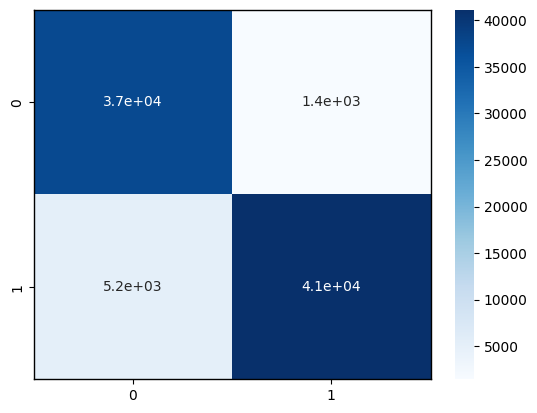

In [23]:
# Confusion Matrix
confmat = torchmetrics.ConfusionMatrix(task="binary", num_classes=2)
cnf_matrix_val = confmat(y_test_20, torch.tensor(y_pred_final).float().unsqueeze(1))
cnf_matrix = sns.heatmap(cnf_matrix_val.numpy(), annot=True, cmap='Blues')
for _, spine in cnf_matrix.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
plt.show()

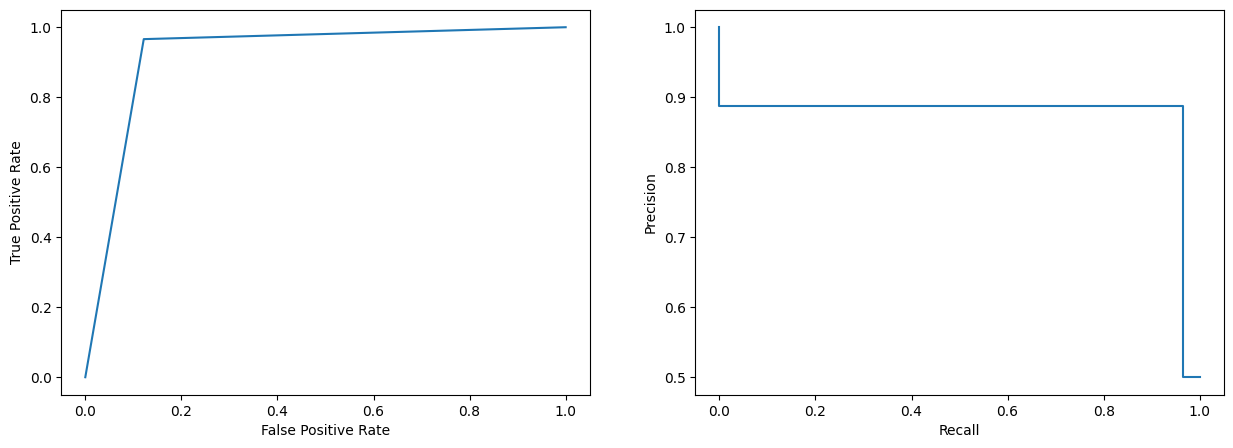

In [26]:
# ROC Curve and Precision-Recall curve
fpr, tpr, _ = roc_curve(y_test_20, torch.tensor(y_pred_final).float().unsqueeze(1).numpy())
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
prec, recall, _ = precision_recall_curve(y_test_20, torch.tensor(y_pred_final).float().unsqueeze(1).numpy())
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()